Dans ce notebook, on calcule la largeur du trottoir

- On lit la donnée sidewalk OSM
- On utilise la librairie centerline
- On explose la ligne
- Finalement, pygeoops donne de meilleurs résultats
- On crée une fonction qui réalise le calcul de stats (largeur du trottoir) en lignes explosées

On utilise la librairie centerline:  
https://centerline.readthedocs.io/en/latest/chapters/usage.html

Il faut reprojeter en métrique:  
https://github.com/fitodic/centerline/issues/9

Alternative:  
Utiliser skgeom pour avoir le squelette https://wolfv.medium.com/introducing-scikit-geometry-ae1dccaad5fd

Vu :

- segmentize
- get_parts
- boundary

Améliorer :

- Enlever les petits segments qui connectent les coins des trottoirs

![](images/enlever.png)

Requête pour les trottoirs : https://overpass-turbo.eu/s/1P4f

Les trottoirs ont été enregistrés en geojson.

In [39]:
import geopandas as gpd

## Lecture

In [40]:
trottoirs = gpd.read_file('../data_tests/trottoirs.geojson')

In [41]:
trottoirs

,id,@id,area:highway,footway,lit,smoothness,source,surface,ID,geometry
0,way/1304641078,way/1304641078,footway,sidewalk,yes,good,Relevés terrain avec Rover Centipede (station:...,asphalt,0,"POLYGON ((5.44389 43.53153, 5.44382 43.53148, ..."
1,way/1304650759,way/1304650759,footway,sidewalk,yes,good,Relevés terrain avec Rover Centipede (station:...,asphalt,1,"POLYGON ((5.44366 43.53083, 5.44367 43.53082, ..."
2,way/1304650760,way/1304650760,footway,sidewalk,yes,good,Relevés terrain avec Rover Centipede (station:...,asphalt,2,"POLYGON ((5.44399 43.53085, 5.44393 43.53083, ..."
3,way/1304650761,way/1304650761,footway,sidewalk,yes,good,Relevés terrain avec Rover Centipede (station:...,asphalt,3,"POLYGON ((5.44381 43.5309, 5.44381 43.5309, 5...."


<Axes: >

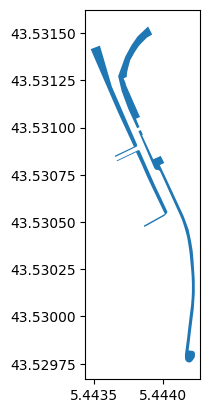

In [42]:
trottoirs.plot()

## Plugin QGIS ne marche pas bien...
- Aller dans OSgeo4W Shell de QGIS

        C:\Program Files\QGIS 3.28.2>pip install networkx
        C:\Program Files\QGIS 3.28.2>pip install segment-geospatial==0.5.0
        
- Ouvrir QGIS 3.28.2
- Aller dans Extensions > SAGA > Activer
    - L'outil a besoin de SAGA dans les Traitements (thiessenpolygons, ...) pour fonctionner
- Aller sous QGIS et installer "Geometric Attributes"
- Aller dans les traitements et retrouver les algos
- Utiliser Polygon Tools > Centerlines

Le résultat n'est pas terrible...

## Centerline
On utiliser la librairie centerline

In [43]:
from shapely.geometry import Polygon
from centerline.geometry import Centerline

exemple :

In [44]:
Polygon([[0, 0], [0, 4], [4, 4], [4, 0]])
Polygon([[0, 0], [0, 4], [4, 4], [4, 0]]).wkt

'POLYGON ((0 0, 0 4, 4 4, 4 0, 0 0))'

⚠ Il faut reprojeter les trottoirs en système métrique : https://github.com/fitodic/centerline/issues/9#issuecomment-429523892

In [45]:
trottoirs2 = trottoirs.set_crs('epsg:4326').to_crs('epsg:3857')

In [46]:
n = trottoirs2.shape[0]

Essai sur tous les objets :

In [47]:
attributes = {"id": 1, "name": "polygon", "valid": True}
for i in range(n):
    print(i)
    try:
        polygon = trottoirs2.iloc[i].geometry
        polygon.wkt
        line = Centerline(polygon, **attributes)
    except:
        print("ko")

0
1
2
3


In [48]:
i

3

## Exemple sur un trottoir

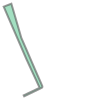

In [49]:
trottoir = trottoirs2.iloc[3]
trottoir
trottoir.geometry

In [50]:
line

In [51]:
line = Centerline(polygon, **attributes)

In [52]:
print(line.id, line.name)

1 polygon


In [53]:
print(line.geometry)

MULTILINESTRING ((605990.0190531545 5393127.001907567, 605989.6746028502 5393126.89248507), (605990.1254192829 5393127.108747596, 605990.0190531545 5393127.001907567), (605990.1254192829 5393127.108747596, 605990.4699608071 5393127.217979833), (605990.4699608071 5393127.217979833, 605990.5762353337 5393127.325010923), (605990.92086885 5393127.434051297, 605990.5762353337 5393127.325010923), (605990.92086885 5393127.434051297, 605991.0270510005 5393127.541275063), (605991.0270510005 5393127.541275063, 605991.3717772851 5393127.650121949), (605991.3717772851 5393127.650121949, 605991.4778662762 5393127.757540026), (605991.4778662762 5393127.757540026, 605991.8226861202 5393127.866191778), (605991.928681156 5393127.9738058215, 605991.8226861202 5393127.866191778), (605992.273595358 5393128.0822607735, 605991.928681156 5393127.9738058215), (605992.273595358 5393128.0822607735, 605992.3794956366 5393128.190072463), (605992.3794956366 5393128.190072463, 605992.7245050059 5393128.298328926), 

In [54]:
print(line.geometry.geoms)

## Essai explosion de ligne

Voici les lignes constituantes (finalement, on choisira de densifier la ligne) :

In [55]:
for elt in line.geometry.geoms:
    print(elt)

LINESTRING (605990.0190531545 5393127.001907567, 605989.6746028502 5393126.89248507)
LINESTRING (605990.1254192829 5393127.108747596, 605990.0190531545 5393127.001907567)
LINESTRING (605990.1254192829 5393127.108747596, 605990.4699608071 5393127.217979833)
LINESTRING (605990.4699608071 5393127.217979833, 605990.5762353337 5393127.325010923)
LINESTRING (605990.92086885 5393127.434051297, 605990.5762353337 5393127.325010923)
LINESTRING (605990.92086885 5393127.434051297, 605991.0270510005 5393127.541275063)
LINESTRING (605991.0270510005 5393127.541275063, 605991.3717772851 5393127.650121949)
LINESTRING (605991.3717772851 5393127.650121949, 605991.4778662762 5393127.757540026)
LINESTRING (605991.4778662762 5393127.757540026, 605991.8226861202 5393127.866191778)
LINESTRING (605991.928681156 5393127.9738058215, 605991.8226861202 5393127.866191778)
LINESTRING (605992.273595358 5393128.0822607735, 605991.928681156 5393127.9738058215)
LINESTRING (605992.273595358 5393128.0822607735, 605992.379

In [56]:
type(line.geometry)

shapely.geometry.multilinestring.MultiLineString

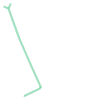

In [57]:
line.geometry

In [58]:
type(line.geometry)

shapely.geometry.multilinestring.MultiLineString

In [59]:
gdf = gpd.GeoDataFrame(geometry = [line.geometry])
gdf

,geometry
0,"MULTILINESTRING ((605990.019 5393127.002, 6059..."


In [60]:
gdf.to_file('centerline.gpkg')

C:\Git-Repos\cim\venv\Lib\site-packages\pyogrio\raw.py:698: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  warnings.warn(


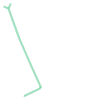

In [74]:
geom

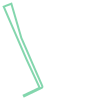

In [80]:
boundary = trottoir.geometry.boundary
boundary

In [77]:
individual_lines = shapely.get_parts(geom)
individual_lines

array([<LINESTRING (605990.019 5393127.002, 605989.675 5393126.892)>,
       <LINESTRING (605990.125 5393127.109, 605990.019 5393127.002)>,
       <LINESTRING (605990.125 5393127.109, 605990.47 5393127.218)>,
       <LINESTRING (605990.47 5393127.218, 605990.576 5393127.325)>,
       <LINESTRING (605990.921 5393127.434, 605990.576 5393127.325)>,
       <LINESTRING (605990.921 5393127.434, 605991.027 5393127.541)>,
       <LINESTRING (605991.027 5393127.541, 605991.372 5393127.65)>,
       <LINESTRING (605991.372 5393127.65, 605991.478 5393127.758)>,
       <LINESTRING (605991.478 5393127.758, 605991.823 5393127.866)>,
       <LINESTRING (605991.929 5393127.974, 605991.823 5393127.866)>,
       <LINESTRING (605992.274 5393128.082, 605991.929 5393127.974)>,
       <LINESTRING (605992.274 5393128.082, 605992.379 5393128.19)>,
       <LINESTRING (605992.379 5393128.19, 605992.725 5393128.298)>,
       <LINESTRING (605992.725 5393128.298, 605992.83 5393128.406)>,
       <LINESTRING (605992.

In [82]:
for elt in individual_lines:
    print(elt.intersects(boundary))

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [88]:
gdf = gpd.GeoDataFrame(geometry = individual_lines)
gdf.to_file('individual_lines.gpkg')
boundary_gdf = gpd.GeoDataFrame(geometry = [boundary])
boundary_gdf.to_file('boundary.gpkg')

C:\Git-Repos\cim\venv\Lib\site-packages\pyogrio\raw.py:698: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  warnings.warn(
C:\Git-Repos\cim\venv\Lib\site-packages\pyogrio\raw.py:698: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  warnings.warn(


cf https://gis.stackexchange.com/questions/341759/generating-transects-perpendicular-to-shapely-geopandas-line

## Densification
En densifiant la ligne, on pourra calculer la distance entre la ligne centrale et les bordures du trottoir (boundary) tous les x mètres

In [61]:
geom = line.geometry

In [62]:
import shapely
new_line = shapely.segmentize(geom, 1)
new_line
type(new_line)

shapely.geometry.multilinestring.MultiLineString

In [63]:
coords = shapely.get_coordinates(new_line)
coords.shape
coords

array([[ 605990.01905315, 5393127.00190757],
       [ 605989.67460285, 5393126.89248507],
       [ 605990.12541928, 5393127.1087476 ],
       ...,
       [ 605971.82142132, 5393213.45724372],
       [ 605972.10528018, 5393214.1097883 ],
       [ 605972.02613452, 5393213.7287717 ]])

get_parts permet d'avoir les lignes constituantes :

In [64]:
lines = shapely.get_parts(geom)
lines
lines.shape

(438,)

In [65]:
for elt in lines:
    print(elt)

LINESTRING (605990.0190531545 5393127.001907567, 605989.6746028502 5393126.89248507)
LINESTRING (605990.1254192829 5393127.108747596, 605990.0190531545 5393127.001907567)
LINESTRING (605990.1254192829 5393127.108747596, 605990.4699608071 5393127.217979833)
LINESTRING (605990.4699608071 5393127.217979833, 605990.5762353337 5393127.325010923)
LINESTRING (605990.92086885 5393127.434051297, 605990.5762353337 5393127.325010923)
LINESTRING (605990.92086885 5393127.434051297, 605991.0270510005 5393127.541275063)
LINESTRING (605991.0270510005 5393127.541275063, 605991.3717772851 5393127.650121949)
LINESTRING (605991.3717772851 5393127.650121949, 605991.4778662762 5393127.757540026)
LINESTRING (605991.4778662762 5393127.757540026, 605991.8226861202 5393127.866191778)
LINESTRING (605991.928681156 5393127.9738058215, 605991.8226861202 5393127.866191778)
LINESTRING (605992.273595358 5393128.0822607735, 605991.928681156 5393127.9738058215)
LINESTRING (605992.273595358 5393128.0822607735, 605992.379

Voici les lignes explosées :

In [66]:
exploded_lines = gpd.GeoDataFrame(geometry = [elt for elt in lines])
exploded_lines.to_file('exploded_lines.gpkg')

C:\Git-Repos\cim\venv\Lib\site-packages\pyogrio\raw.py:698: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  warnings.warn(


## Calcul des distances
On calcule la distance sur chaque mini segment :

In [67]:
trottoir
boundary = trottoir.geometry.boundary
type(trottoir.geometry.boundary)

shapely.geometry.linestring.LineString

In [68]:
ds = list()
for i in range(exploded_lines.shape[0]):
    print(i)
    exploded_line = exploded_lines.geometry[i]
    d = shapely.distance(exploded_line, boundary) * 2
    print(d)
    ds.append(d)

0
0.9603390000208726
1
0.9589851611241133
2
0.955895517561614
3
0.9545404050108688
4
0.9514502515482227
5
0.9500938506234772
6
0.9470031817151705
7
0.9456454732635257
8
0.9425542830241969
9
0.94119525211051
10
0.938103531146639
11
0.9367431606097616
12
0.9336509047011836
13
0.9322891773290335
14
0.9291963790545227
15
0.9278332760129646
16
0.9247399279999818
17
0.9233754315640602
18
0.9202815282256082
19
0.918915619809008
20
0.9113587755544619
21
0.9099899888549301
22
0.9068943705991368
23
0.9055241161343565
24
0.9024279128068768
25
0.9010561702092714
26
0.8979593703320288
27
0.8965861226424986
28
0.8934887209809034
29
0.8921139434871765
30
0.8890159311301433
31
0.8876396067610001
32
0.8845409745229222
33
0.8831630804613144
34
0.8800638212943812
35
0.8786843381936061
36
0.875584443105348
37
0.874203346471792
38
0.8711028064340194
39
0.8697200753358815
40
0.8666188829412232
41
0.9158211515426983
42
0.9144538138675755
43
0.8652344944661872
44
0.8621326386989631
45
0.8127871691589664
46
0.

In [69]:
exploded_lines['distance'] = ds

In [70]:
exploded_lines.to_file('exploded_lines.gpkg')

C:\Git-Repos\cim\venv\Lib\site-packages\pyogrio\raw.py:698: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  warnings.warn(


## Fonction **calculate_sidewalk_width**

In [71]:
trottoirs2.id

0    way/1304641078
1    way/1304650759
2    way/1304650760
3    way/1304650761
Name: id, dtype: object

In [72]:
import pandas as pd

def calculate_sidewalk_width(trottoirs, distance = 1):
    n = trottoirs.shape[0]
    gdfs = list()
    for i in range(n):
        # Trottoir
        print(i)
        attributes = {"id": 1, "name": "polygon", "valid": True}
        trottoir = trottoirs.iloc[i]
        pol = trottoir.geometry
        line = Centerline(pol, **attributes)
        geom = line.geometry
        dense_line = shapely.segmentize(geom, 1)
        exploded_lines = shapely.get_parts(dense_line)
        boundary = pol.boundary
        ds = list()
        for exploded_line in exploded_lines:
            d = shapely.distance(exploded_line, boundary) * 2
            ds.append(d)
        gdf = gpd.GeoDataFrame(geometry = exploded_lines)
        gdf['distance'] = ds
        gdf['id'] = trottoir.id
        gdfs.append(gdf)

    gdf_total = pd.concat(gdfs)
    return(gdf_total)
   
gdf_total = calculate_sidewalk_width(trottoirs2)
gdf_total.shape

0
1
2
3


(2037, 3)

Export :

In [73]:
gdf_total.to_file('exploded_lines_total.gpkg')

C:\Git-Repos\cim\venv\Lib\site-packages\pyogrio\raw.py:698: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  warnings.warn(


![image](images/1.jpeg)

## Essai avec pygeops

In [89]:
import pygeoops

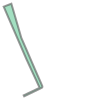

In [91]:
polygon

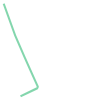

In [110]:
center_line = pygeoops.centerline(polygon, min_branch_length=5, simplifytolerance=0, densify_distance  = 1)
center_line

In [111]:
gpd.GeoDataFrame(geometry = [center_line]).to_file('essaie.gpkg')

C:\Git-Repos\cim\venv\Lib\site-packages\pyogrio\raw.py:698: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  warnings.warn(


## Utilisation de pygeoops

In [150]:
def segments(curve):
    return list(map(shapely.LineString, zip(curve.coords[:-1], curve.coords[1:])))

trottoir = trottoirs2.iloc[0]
pol = trottoir.geometry
geom = pygeoops.centerline(pol, min_branch_length=5, simplifytolerance = -0.25, densify_distance = 1)
geom
dense_line = shapely.segmentize(geom, 1)
dense_line = segments(dense_line)
len(dense_line)
# boundary = pol.boundary
# ds = list()
# for exploded_line in exploded_lines:
#     d = shapely.distance(exploded_line, boundary) * 2
#     ds.append(d)
# gdf = gpd.GeoDataFrame(geometry = exploded_lines)
# gdf['distance'] = ds
# gdf['id'] = trottoir.id

181

In [155]:
import pandas as pd

def calculate_sidewalk_width(trottoirs, distance = 1):
    n = trottoirs.shape[0]
    gdfs = list()
    for i in range(n):
        # Trottoir
        print(i)
        trottoir = trottoirs2.iloc[i]
        pol = trottoir.geometry
        geom = pygeoops.centerline(pol, min_branch_length = 5, simplifytolerance = -0.25, densify_distance = 1)
        geom
        dense_line = shapely.segmentize(geom, 1)
        exploded_lines = segments(dense_line)
        boundary = pol.boundary
        ds = list()
        for exploded_line in exploded_lines:
            d = shapely.distance(exploded_line, boundary) * 2
            ds.append(d)
        gdf = gpd.GeoDataFrame(geometry = exploded_lines)
        gdf['distance'] = ds
        gdf['id'] = trottoir.id
        gdfs.append(gdf)

    gdf_total = pd.concat(gdfs)
    return(gdf_total)
   
gdf_total = calculate_sidewalk_width(trottoirs2)
gdf_total.shape

0
1
2
3


(482, 3)

<Axes: >

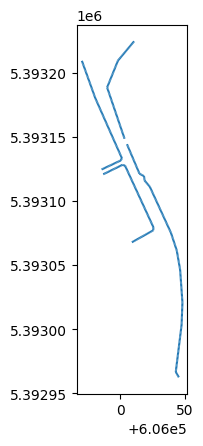

In [156]:
gdf_total.plot()

In [157]:
gdf_total.to_file('center_line2.gpkg')

C:\Git-Repos\cim\venv\Lib\site-packages\pyogrio\raw.py:698: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  warnings.warn(
